# 01 Sanitize ecoli and bsub shell output

In [28]:
import pandas as pd
import numpy as np
import re
import seaborn as sns

def filter_data(x):
    if 'Epoch' in x or 'lwaldburger' in x or 'Better model found' in x or '█' in x or 'Script' in x or '[?2004' in x or 'exit' in x or x == 'c' or x == 'd' or '^[[B^[[B^C0+1' in x or '0+0' in x or '0 bytes copied' in x:
        return False
    else:
        return True
    
def sanitize_row(x):
    str_builder = x
    for re_match in re.findall(r'[-]+',x):
        str_builder = str_builder.replace(re_match,' ')
    return str_builder

def add_model(df):
    models = ['+ horizontal flip + zoom','- horizontal flip + zoom','+ horizontal flip - zoom','- horizontal flip - zoom']
    curr_model = 0

    df['model'] = None
    for idx,row in df.iterrows():
        df.loc[idx,'model'] = models[curr_model]
        if row['epoch'] == 'epoch':
            curr_model += 1
    df = df[df['epoch'] != 'epoch'].reset_index(drop=True)
    return df

def parse_log(log_path):
    df = pd.read_csv(log_path,sep='\t',names=['text'])
    df = df[df['text'].apply(lambda x: filter_data(x))].reset_index(drop=True)
    df['text'] = df['text'].apply(lambda x: x.replace(' ','-'))
    df['text'] = df['text'].apply(lambda x: sanitize_row(x) )
    df.to_csv('temp.csv',index=False,header=False)
    df = pd.read_csv('temp.csv',sep=' ',index_col=False).drop(['Unnamed: 5',
           'Unnamed: 6'],axis=1)
    df = add_model(df)
    return df

ecoli_df = parse_log('outputs/ecoli/ecoli_history_log.txt')
ecoli_df['organism'] = 'E. coli'
bsub_df = parse_log('outputs/bsub/bsubtilis_history_log.txt')
bsub_df['organism'] = 'B. subtilis'
df = pd.concat([ecoli_df,bsub_df])
df.head(4)

,epoch,train_loss,valid_loss,accuracy,time,model,organism
0,0,1.068508,0.646138,0.691839,08:45,+ horizontal flip + zoom,E. coli
1,1,0.917510,0.503040,0.775883,08:37,+ horizontal flip + zoom,E. coli
2,2,0.762349,0.453377,0.806334,08:36,+ horizontal flip + zoom,E. coli
3,3,0.734627,0.410023,0.825822,08:36,+ horizontal flip + zoom,E. coli


# 02 Plot model performance

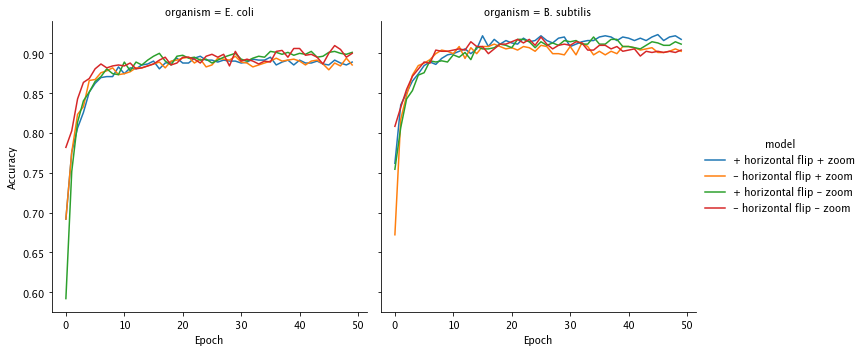

In [29]:
df['accuracy'] = df['accuracy'].astype(float)
df['epoch'] = df['epoch'].astype(float)
df['train_loss'] = df['train_loss'].astype(float)
df['valid_loss'] = df['valid_loss'].astype(float)

g = sns.relplot(kind='line',data=df,hue='model',x='epoch',col='organism',y='accuracy')
g.set(xlabel='Epoch',ylabel='Accuracy')

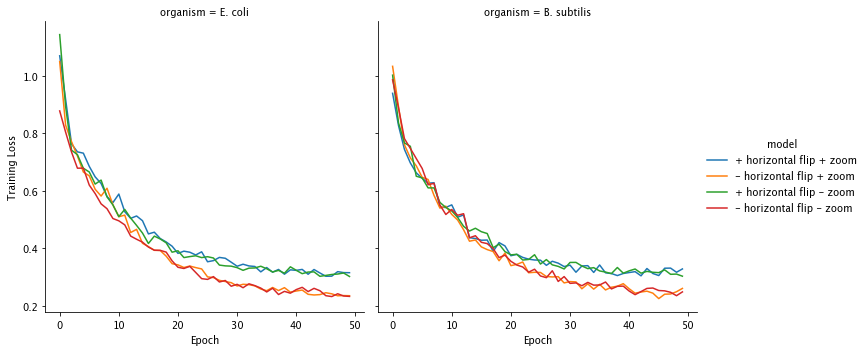

In [30]:
g = sns.relplot(kind='line',data=df,hue='model',x='epoch',col='organism',y='train_loss')
g.set(xlabel='Epoch',ylabel='Training Loss')

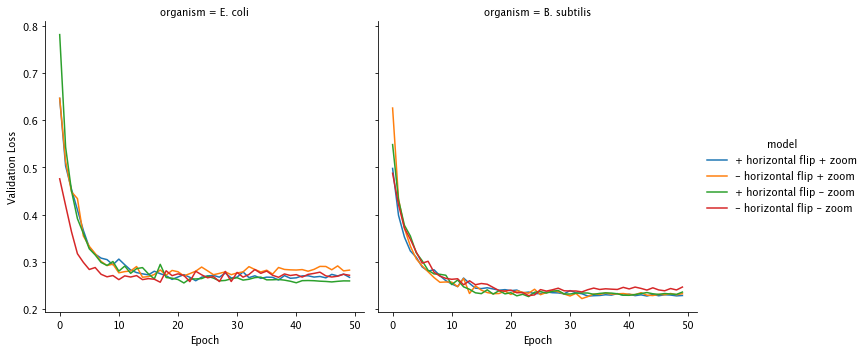

In [31]:
g = sns.relplot(kind='line',data=df,hue='model',x='epoch',col='organism',y='valid_loss')
g.set(xlabel='Epoch',ylabel='Validation Loss')

In [43]:
df['organism_model'] = df['organism'] + ' | ' + df['model']

0          E. coli | + horizontal flip + zoom
1          E. coli | + horizontal flip + zoom
2          E. coli | + horizontal flip + zoom
3          E. coli | + horizontal flip + zoom
4          E. coli | + horizontal flip + zoom
                        ...                  
195    B. subtilis | - horizontal flip - zoom
196    B. subtilis | - horizontal flip - zoom
197    B. subtilis | - horizontal flip - zoom
198    B. subtilis | - horizontal flip - zoom
199    B. subtilis | - horizontal flip - zoom
Name: organism_model, Length: 400, dtype: object

/Users/waldburger/opt/anaconda3/lib/python3.9/site-packages/seaborn/categorical.py:1296: UserWarning: 38.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/waldburger/opt/anaconda3/lib/python3.9/site-packages/seaborn/categorical.py:1296: UserWarning: 30.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/waldburger/opt/anaconda3/lib/python3.9/site-packages/seaborn/categorical.py:1296: UserWarning: 28.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/waldburger/opt/anaconda3/lib/python3.9/site-packages/seaborn/categorical.py:1296: UserWarning: 26.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/waldburger/opt/anaconda3/lib/

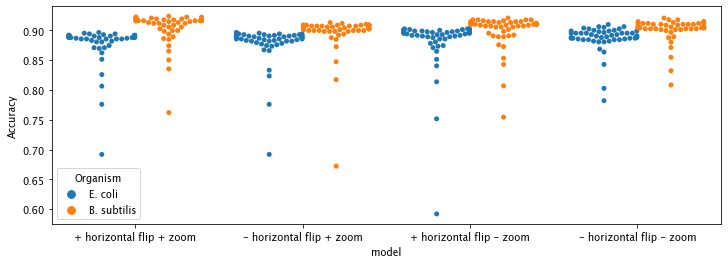

In [87]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12,4))
df['Organism'] = df['organism']
g = sns.swarmplot(data=df,x='model',y='accuracy',hue='Organism',dodge=True)
g.set(ylabel='Accuracy')
fig = g.get_figure()
fig.savefig('ablation.svg',dpi=300)

# 03 Classifer performance

In [32]:
TOTAL_ECOLI_OPERONS = None
TOTAL_ECOLI_NOPERONS = None
TOTAL_BSUB_OPERONS = None
TOTAL_BSUB_NOPERONS = None
!ls 

2018_Book_AgrobacteriumBiology.pdf
2022 Certification of Summer Study Research_GFB.pdf
2022-05-03-presentation.pptx
2022.04.20.488937v2.full.pdf
Copy of Illumina Sequencing Submission Template - Export.csv
Copy of Illumina Sequencing Submission Template - Input.csv
LOICA_SEED2022.ipynb
QB3 Sample Manifest.Submission#M002075_2022-05-04.pdf
Quote_Submission#M002075_2022-05-04.pdf
SEED_hotel.pdf
Untitled.ipynb
Zotero-6.0.6.dmg
ecoli_df.csv
lac_operon_wiki.png
organize
outputs
sandbox.pptx
tab.0186.pdf
temp.csv
test.csv


In [23]:
from glob import glob

file_dict = {}
for txt_file in glob('outputs/ecoli/*pegs*'):
    filename = txt_file.split('/')[-1]
    with open(txt_file) as f:
        peg_list = f.readlines()
        peg_list = [peg_entry.replace('\n','') for peg_entry in peg_list]
    f.close()
    file_dict[filename] = peg_list

In [27]:
pd.DataFrame.from_dict(file_dict,orient='index')

,0,1,2,3,4,5,6,7,8,9,...,422,423,424,425,426,427,428,429,430,431
noperon_pegs_no_zoom_no_hflip.txt,fig|511145.12.peg.1835,fig|511145.12.peg.4146,fig|511145.12.peg.827,fig|511145.12.peg.79,fig|511145.12.peg.4091,fig|511145.12.peg.2669,fig|511145.12.peg.240,fig|511145.12.peg.3660,fig|511145.12.peg.4270,fig|511145.12.peg.3348,...,fig|511145.12.peg.4490,fig|511145.12.peg.2061,fig|511145.12.peg.1706,fig|511145.12.peg.3657,fig|511145.12.peg.4138,fig|511145.12.peg.703,fig|511145.12.peg.3075,fig|511145.12.peg.932,fig|511145.12.peg.1257,fig|511145.12.peg.2392
noperon_pegs_no_zoom_only.txt,fig|511145.12.peg.4146,fig|511145.12.peg.827,fig|511145.12.peg.79,fig|511145.12.peg.4091,fig|511145.12.peg.2669,fig|511145.12.peg.240,fig|511145.12.peg.3660,fig|511145.12.peg.4270,fig|511145.12.peg.3348,fig|511145.12.peg.3556,...,fig|511145.12.peg.3075,fig|511145.12.peg.932,fig|511145.12.peg.1257,fig|511145.12.peg.2392,None,None,None,None,None,None
noperon_pegs.txt,fig|511145.12.peg.1835,fig|511145.12.peg.4146,fig|511145.12.peg.827,fig|511145.12.peg.79,fig|511145.12.peg.4091,fig|511145.12.peg.2669,fig|511145.12.peg.240,fig|511145.12.peg.3660,fig|511145.12.peg.4270,fig|511145.12.peg.3348,...,None,None,None,None,None,None,None,None,None,None
operon_pegs.txt,fig|511145.12.peg.1840,fig|511145.12.peg.3087,fig|511145.12.peg.1962,fig|511145.12.peg.3695,fig|511145.12.peg.3615,fig|511145.12.peg.235,fig|511145.12.peg.3481,fig|511145.12.peg.2766,fig|511145.12.peg.4049,fig|511145.12.peg.3579,...,None,None,None,None,None,None,None,None,None,None
operon_pegs_no_zoom_no_hflip.txt,fig|511145.12.peg.1840,fig|511145.12.peg.3087,fig|511145.12.peg.1962,fig|511145.12.peg.3695,fig|511145.12.peg.3615,fig|511145.12.peg.235,fig|511145.12.peg.3481,fig|511145.12.peg.2631,fig|511145.12.peg.2766,fig|511145.12.peg.4049,...,None,None,None,None,None,None,None,None,None,None
noperon_pegs_no_hflp.txt,fig|511145.12.peg.1835,fig|511145.12.peg.4146,fig|511145.12.peg.827,fig|511145.12.peg.79,fig|511145.12.peg.4091,fig|511145.12.peg.2669,fig|511145.12.peg.240,fig|511145.12.peg.3660,fig|511145.12.peg.4270,fig|511145.12.peg.3348,...,None,None,None,None,None,None,None,None,None,None
operon_pegs_no_hflp.txt,fig|511145.12.peg.1840,fig|511145.12.peg.3087,fig|511145.12.peg.1962,fig|511145.12.peg.3695,fig|511145.12.peg.3615,fig|511145.12.peg.235,fig|511145.12.peg.2766,fig|511145.12.peg.4049,fig|511145.12.peg.3579,fig|511145.12.peg.2779,...,None,None,None,None,None,None,None,None,None,None
operon_pegs_no_zoom_only.txt,fig|511145.12.peg.1840,fig|511145.12.peg.3087,fig|511145.12.peg.1962,fig|511145.12.peg.3695,fig|511145.12.peg.3615,fig|511145.12.peg.235,fig|511145.12.peg.3481,fig|511145.12.peg.2631,fig|511145.12.peg.2766,fig|511145.12.peg.4049,...,None,None,None,None,None,None,None,None,None,None


In [ ]:
# TODO
# import dataframe where pegs are a list
# make venn diagrams of ablation
# calculate operon prediction pegs for ecoli and bsub